In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip -q install torch-spline-conv==latest+cu102 torch-scatter==latest+cu102 torch-cluster==latest+cu102 torch-sparse==latest+cu102  -f https://pytorch-geometric.com/whl/torch-1.6.0.html

#!pip -q install torch-geometric==1.7.0    
!pip install -q git+https://github.com/elmahyai/pytorch_geometric_temporal   # remove after merging
#!pip -q install torch-geometric-temporal

1.6.0
10.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

# GPU support
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

<h1>
<center>A3T-GCN: Attention Temporal Graph
Convolutional Network for Traffic Forecasting</center>
</h1>


## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [34]:
# 读取数据，目前只使用前 100 个节点的数据

import pandas as pd

adj_fp = '/home/shuowang/data/aod_pm25/adjacency_matrix.npy'
adj = np.load(adj_fp)
adj = adj[:100,:100]

data_xs = []
data_ys = []


for i in range(100):
    
    fp = '/home/shuowang/data/aod_pm25/interpolated_data/UNIQUE-ID_{}.csv'.format(i)
    data = pd.read_csv(fp)

    # select the columns
    data_x = data[['AOD', 'NO2', 'STRM', 'LANDUC', 'NDVI', 'T', 'D', 'SP', 'U10', 'V10', 'BLH', 'TP', 'E', 'RH', 'TCW', 'O']]
    data_y = data['PM2.5']
    data_x = data_x.to_numpy()
    data_y = data_y.to_numpy()[..., np.newaxis]

    data_xs.append(data_x)
    data_ys.append(data_y)

data_xs = np.stack(data_xs, axis=0)
data_ys = np.stack(data_ys, axis=0)

ValueError: all input arrays must have the same shape

In [32]:
data_x.shape

(324, 16)

In [6]:
print(data.columns.tolist())

['Unnamed: 0', 'LON', 'LAT', 'ID', 'ROW', 'COL', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'AOD', 'NO2', 'STRM', 'LANDUC', 'NDVI', 'T', 'D', 'SP', 'U10', 'V10', 'BLH', 'TP', 'E', 'RH', 'TCW', 'O', 'PM2.5', 'UNIQUE-ID']


In [14]:
import os
import urllib
import zipfile
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric_temporal.signal import StaticGraphTemporalSignal


class METRLADatasetLoader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir=os.path.join(os.getcwd(), "data")):
        super(METRLADatasetLoader, self).__init__()
        self.raw_data_dir = raw_data_dir
        self._read_web_data()

    def _download_url(self, url, save_path):  # pragma: no cover
        with urllib.request.urlopen(url) as dl_file:
            with open(save_path, "wb") as out_file:
                out_file.write(dl_file.read())

    def _read_web_data(self):
        url = "https://graphmining.ai/temporal_datasets/METR-LA.zip"

        # Check if zip file is in data folder from working directory, otherwise download
        if not os.path.isfile(
            os.path.join(self.raw_data_dir, "METR-LA.zip")
        ):  # pragma: no cover
            if not os.path.exists(self.raw_data_dir):
                os.makedirs(self.raw_data_dir)
            self._download_url(url, os.path.join(self.raw_data_dir, "METR-LA.zip"))

        if not os.path.isfile(
            os.path.join(self.raw_data_dir, "adj_mat.npy")
        ) or not os.path.isfile(
            os.path.join(self.raw_data_dir, "node_values.npy")
        ):  # pragma: no cover
            with zipfile.ZipFile(
                os.path.join(self.raw_data_dir, "METR-LA.zip"), "r"
            ) as zip_fh:
                zip_fh.extractall(self.raw_data_dir)

        A = np.load(os.path.join(self.raw_data_dir, "adj_mat.npy"))
        X = np.load(os.path.join(self.raw_data_dir, "node_values.npy")).transpose(
            (1, 2, 0)
        )
        X = X.astype(np.float32)

        # Normalise as in DCRNN paper (via Z-Score Method)
        means = np.mean(X, axis=(0, 2))
        X = X - means.reshape(1, -1, 1)
        stds = np.std(X, axis=(0, 2))
        X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self, num_timesteps_in: int = 12, num_timesteps_out: int = 12):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(
        self, num_timesteps_in: int = 12, num_timesteps_out: int = 12
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset

In [16]:
# 手动下载 https://graphmining.ai/temporal_datasets/METR-LA.zip，保存到 /home/shuowang/workspace/pytorch_geometric_temporal/notebooks/data/

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
# print("Number of samples / sequences: ",  len(set(dataset)))
# print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7ff8031fc640>


#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

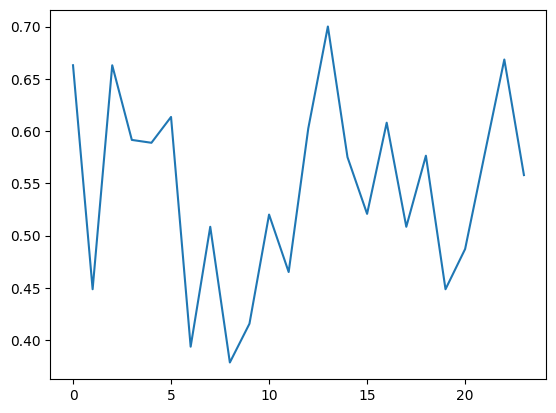

In [17]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

# Test Train Split

In [19]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# print("Number of train buckets: ", len(set(train_dataset)))
# print("Number of test buckets: ", len(set(test_dataset)))

# Creating DataLoaders


In [20]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [21]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

## Model

Which model to choose depends on which time-series task you work on. 

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

<html>
<img src="https://i.ibb.co/WxrJQbc/a3tgcn.png", height="300"></img>

# TGCN model
A temporal GCN (T-GCN) model was constructed by combining GCN and GRU. 

n historical time series traffic data were inputted into the T-GCN model to obtain n hidden states (h) that covered spatiotemporal characteristics:{h(t−n), · · · , h(t−1), h(t)}


ut = σ(Wu ∗ (GC(A, Xt), ht−1)) 

rt = σ(Wr ∗ (GC(A, Xt), ht−1)) 

ct = tanh(Wc ∗ (GC(A, Xt), (rt ∗ ht−1)))

ht = ut ∗ ht−1 + (1 − ut) ∗ ct) 


Then, the hidden states were inputted into the attention model to determine the context vector that covers the global traffic variation information. Particularly, the weight of each h was calculated by Softmax using a multilayer perception:{at−n, · · · , at−1, at}.The context vector that covers global traffic variation information is calculated by the weighted sum. 


# A3TGCN Model
The A3TGCN is an extention of the TGCN model by adding an attention mechanism.

The attention mechanism was introduced to re-weight the influence of historical traffic states and thus to capture the global variation trends of traffic state

In [22]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## Training

In [23]:

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

# Loading the graph once 
because it's a static graph

In [24]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [25]:
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.7763196033239365
0.6563107833266258
0.6051057787736257
0.5762667318433523
0.5593440510630607
0.5463698877890905
0.5330807330352919
0.525275404304266
Epoch 0 train RMSE: 0.5234


## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [26]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.6029


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [27]:
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

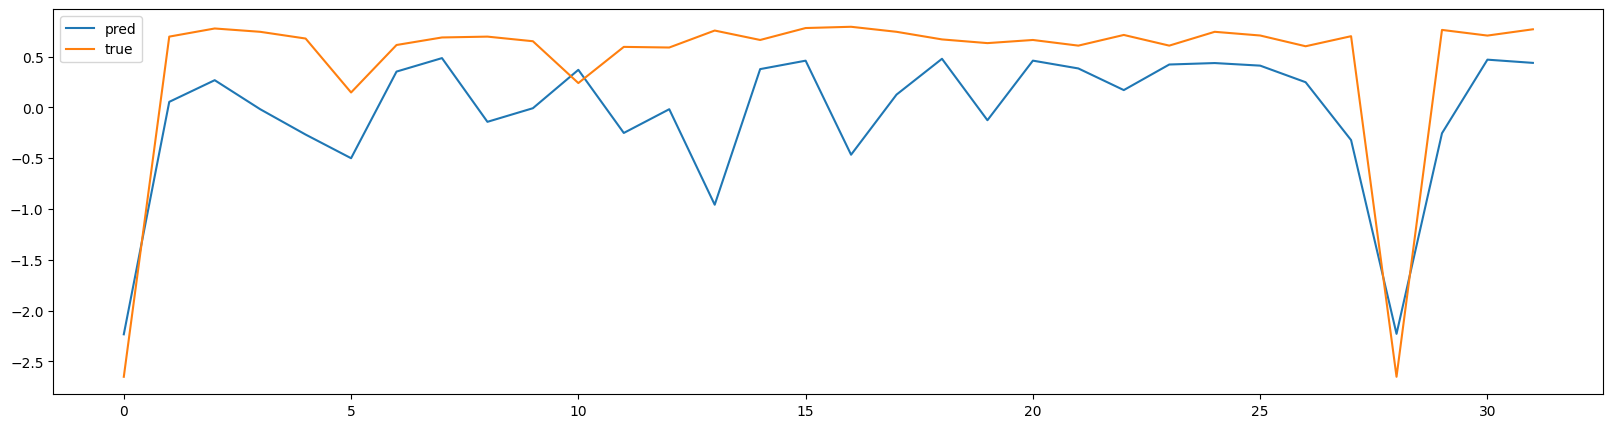

In [28]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")